In [1]:
#pip install yfinance

In [2]:
import numpy as np
import datetime
import time
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, balanced_accuracy_score
import pydotplus
from IPython.display import Image
%matplotlib inline
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.linear_model import LogisticRegression
from imblearn.metrics import classification_report_imbalanced
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.datasets import make_classification
import dataframe_image as dfi
from sklearn.metrics import precision_recall_curve
from matplotlib.pyplot import figure

In [3]:
ticker = 'MSFT'
start_date = '2011-01-01'
end_date = '2021-05-31'

stock_df = yf.download(ticker, start=start_date, end=end_date)
stock_df['Daily Return'] = stock_df['Close'].pct_change().dropna()
stock_df['Adj Daily Return'] = stock_df['Close'].pct_change().dropna().shift()
#stock_df['Daily Rolling Volatility'] = stock_df['Daily Return'].rolling(window=10).std()
stock_df['Adj Daily Rolling Volatility'] = stock_df['Daily Return'].rolling(window=10).std().shift()
stock_df['Decision'] = np.where(stock_df['Adj Daily Return'] > 0, 'Entry' , 'Exit')
stock_df.dropna(inplace=True)
stock_df.drop(['Close', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
stock_df.to_csv('Export Files\decision df.csv', index=False)
stock_df.tail(20)

[*********************100%***********************]  1 of 1 completed


,Open,Daily Return,Adj Daily Return,Adj Daily Rolling Volatility,Decision
Date,,,,,
2021-05-03,253.399994,-0.001269,-0.001307,0.012104,Exit
2021-05-04,250.970001,-0.016160,-0.001269,0.012014,Exit
2021-05-05,249.059998,-0.005327,-0.016160,0.012742,Exit
2021-05-06,246.449997,0.013227,-0.005327,0.011890,Exit
2021-05-07,252.149994,0.010932,0.013227,0.012891,Entry
2021-05-10,250.869995,-0.020914,0.010932,0.012236,Entry
2021-05-11,244.550003,-0.003843,-0.020914,0.013265,Exit
2021-05-12,242.169998,-0.029363,-0.003843,0.013048,Exit
2021-05-13,241.800003,0.016862,-0.029363,0.013254,Exit


In [4]:
X = stock_df.copy()
X.drop(['Decision', 'Daily Return', 'Adj Daily Return'], axis=1, inplace=True)
X.dropna(inplace=True)
X.tail(20)

,Open,Adj Daily Rolling Volatility
Date,,
2021-05-03,253.399994,0.012104
2021-05-04,250.970001,0.012014
2021-05-05,249.059998,0.012742
2021-05-06,246.449997,0.011890
2021-05-07,252.149994,0.012891
2021-05-10,250.869995,0.012236
2021-05-11,244.550003,0.013265
2021-05-12,242.169998,0.013048
2021-05-13,241.800003,0.013254


In [5]:
y = stock_df['Decision'].values.reshape(-1,1)
y[:20]

array([['Entry'],
       ['Exit'],
       ['Exit'],
       ['Exit'],
       ['Entry'],
       ['Entry'],
       ['Entry'],
       ['Entry'],
       ['Exit'],
       ['Exit'],
       ['Entry'],
       ['Exit'],
       ['Exit'],
       ['Entry'],
       ['Entry'],
       ['Entry'],
       ['Exit'],
       ['Exit'],
       ['Exit'],
       ['Exit']], dtype=object)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=78)

scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [7]:
model = tree.DecisionTreeClassifier()
model = model.fit(X_train_scaled, y_train)

In [8]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    model = GradientBoostingClassifier(
        n_estimators=1000,
        learning_rate=learning_rate,
        max_features=2,
        max_depth=3,
        random_state=78)
    model.fit(X_train_scaled,y_train.ravel())
    print("Learning rate: ", learning_rate)

    # Score the model
    print("Accuracy score (training): {0:.5f}".format(
        model.score(
            X_train_scaled,
            y_train.ravel())))
    print("Accuracy score (validation): {0:.5f}".format(
        model.score(
            X_test_scaled,
            y_test.ravel())))
    print()

Learning rate:  0.05
Accuracy score (training): 0.87945
Accuracy score (validation): 0.51596

Learning rate:  0.1
Accuracy score (training): 0.96164
Accuracy score (validation): 0.52235

Learning rate:  0.25
Accuracy score (training): 1.00000
Accuracy score (validation): 0.51469

Learning rate:  0.5
Accuracy score (training): 1.00000
Accuracy score (validation): 0.50702

Learning rate:  0.75
Accuracy score (training): 1.00000
Accuracy score (validation): 0.53257

Learning rate:  1
Accuracy score (training): 1.00000
Accuracy score (validation): 0.50192



In [9]:
predictions = model.predict(X_test_scaled)

In [10]:
predictions_df = pd.DataFrame({"Actual": y_test.ravel(),"Prediction": predictions}, index=stock_df.index[-len(y_test):])
predictions_df.head(20)

,Actual,Prediction
Date,,
2018-04-20,Entry,Entry
2018-04-23,Entry,Entry
2018-04-24,Entry,Entry
2018-04-25,Entry,Exit
2018-04-26,Exit,Exit
2018-04-27,Entry,Exit
2018-04-30,Entry,Entry
2018-05-01,Exit,Exit
2018-05-02,Exit,Exit


In [11]:
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual Entry", "Actual Exit"], columns=["Predicted Entry", "Predicted Exit"]
)

acc_score = accuracy_score(y_test, predictions)

In [12]:
print('Confusion Matrix')
display(cm_df)
print()
print()
print(f'Accuracy Score: {acc_score:.5f}')
print()
print()
print('Classification Report')
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted Entry,Predicted Exit
Actual Entry,213,187
Actual Exit,203,180




Accuracy Score: 0.50192


Classification Report
              precision    recall  f1-score   support

       Entry       0.51      0.53      0.52       400
        Exit       0.49      0.47      0.48       383

    accuracy                           0.50       783
   macro avg       0.50      0.50      0.50       783
weighted avg       0.50      0.50      0.50       783



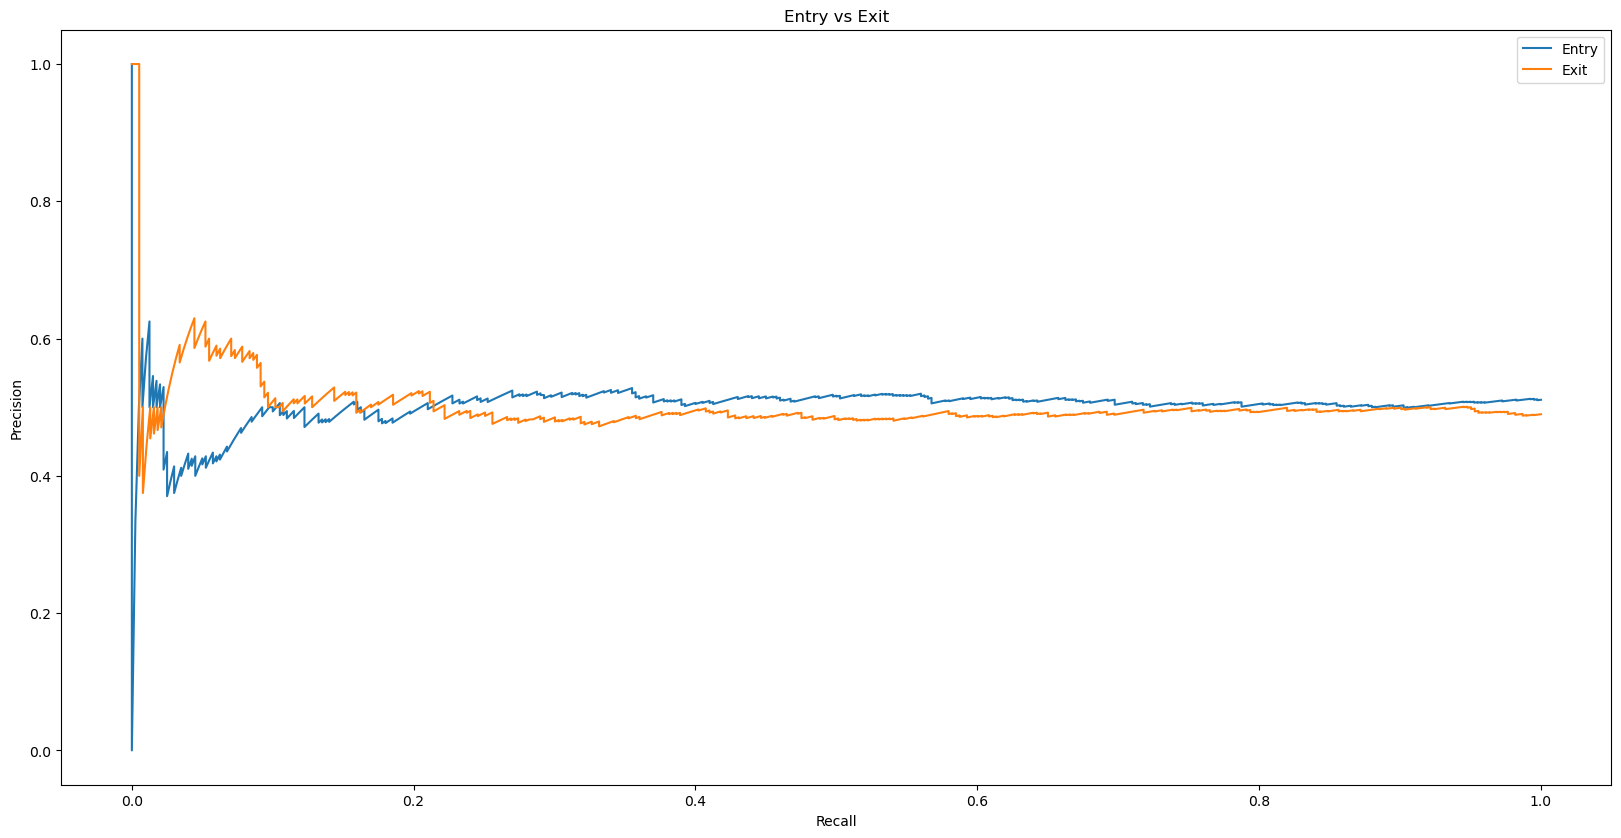

In [13]:
probs = model.predict_proba(X_test_scaled)[:, 1]

precision_entry, recall_entry, _ = precision_recall_curve(y_test, probs, pos_label='Entry')
precision_exit, recall_exit, _ = precision_recall_curve(y_test, probs, pos_label='Exit')
plt.figure(figsize=(20,10), dpi=100)
plt.plot(recall_entry, precision_entry, label='Entry')
plt.plot(recall_exit, precision_exit,label='Exit')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Entry vs Exit')
plt.savefig('Images\Precision Recall.jpeg')
plt.show()

In [14]:
dot_data = tree.export_graphviz(
    model.estimators_[9, 0],
    out_file=None, filled=True,
    rounded=True,
    special_characters=True,
    proportion=True,
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())


InvocationException: GraphViz's executables not found

In [39]:
graph.write_png("Images/entry exit tree.png")

InvocationException: GraphViz's executables not found

## Random Oversampling

In [15]:
ros = RandomOverSampler(random_state=78)
X_over_resampled, y_over_resampled = ros.fit_resample(X_train_scaled, y_train)
Counter(y_over_resampled)

Counter({'Exit': 963, 'Entry': 963})

In [16]:
model_over_resample = LogisticRegression(solver='lbfgs', random_state=78)
model_over_resample.fit(X_over_resampled, y_over_resampled)
y_pred_over = model.predict(X_test_scaled)
cm_over = confusion_matrix(y_test, y_pred_over)
cm_over_df = pd.DataFrame(
    cm_over, index=["Actual Entry", "Actual Exit"], columns=["Predicted Entry", "Predicted Exit"]
)
bac_over = balanced_accuracy_score(y_test, y_pred_over)

In [17]:
print('Confusion Matrix')
display(cm_over_df)
print()
print()
print(f'Balance Accuracy Score: {bac_over:.5f}')
print()
print()
print('Classification Report (Imbalanced)')
print(classification_report_imbalanced(y_test, y_pred_over))

Confusion Matrix


,Predicted Entry,Predicted Exit
Actual Entry,213,187
Actual Exit,203,180




Balance Accuracy Score: 0.50124


Classification Report (Imbalanced)
                   pre       rec       spe        f1       geo       iba       sup

      Entry       0.51      0.53      0.47      0.52      0.50      0.25       400
       Exit       0.49      0.47      0.53      0.48      0.50      0.25       383

avg / total       0.50      0.50      0.50      0.50      0.50      0.25       783



In [18]:
classification_report_os = pd.DataFrame(classification_report_imbalanced(y_test, y_pred_over,digits=2, output_dict=True)).T
classification_report_os.to_csv('Export Files\classification_report imbalanced (Oversampling).csv', index=False)
dfi.export(classification_report_os.style.background_gradient(cmap='viridis', subset=pd.IndexSlice['Entry':'Exit']),'Images\classification_report imbalanced (Oversampling).png')
classification_report_os.style.background_gradient(cmap='viridis', subset=pd.IndexSlice['Entry':'Exit'])

,pre,rec,spe,f1,geo,iba,sup
Entry,0.512019,0.532500,0.469974,0.522059,0.500261,0.251826,400.000000
Exit,0.490463,0.469974,0.532500,0.480000,0.500261,0.248696,383.000000
avg_pre,0.501475,0.501475,0.501475,0.501475,0.501475,0.501475,0.501475
avg_rec,0.501916,0.501916,0.501916,0.501916,0.501916,0.501916,0.501916
avg_spe,0.500558,0.500558,0.500558,0.500558,0.500558,0.500558,0.500558
avg_f1,0.501486,0.501486,0.501486,0.501486,0.501486,0.501486,0.501486
avg_geo,0.500261,0.500261,0.500261,0.500261,0.500261,0.500261,0.500261
avg_iba,0.250295,0.250295,0.250295,0.250295,0.250295,0.250295,0.250295
total_support,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000


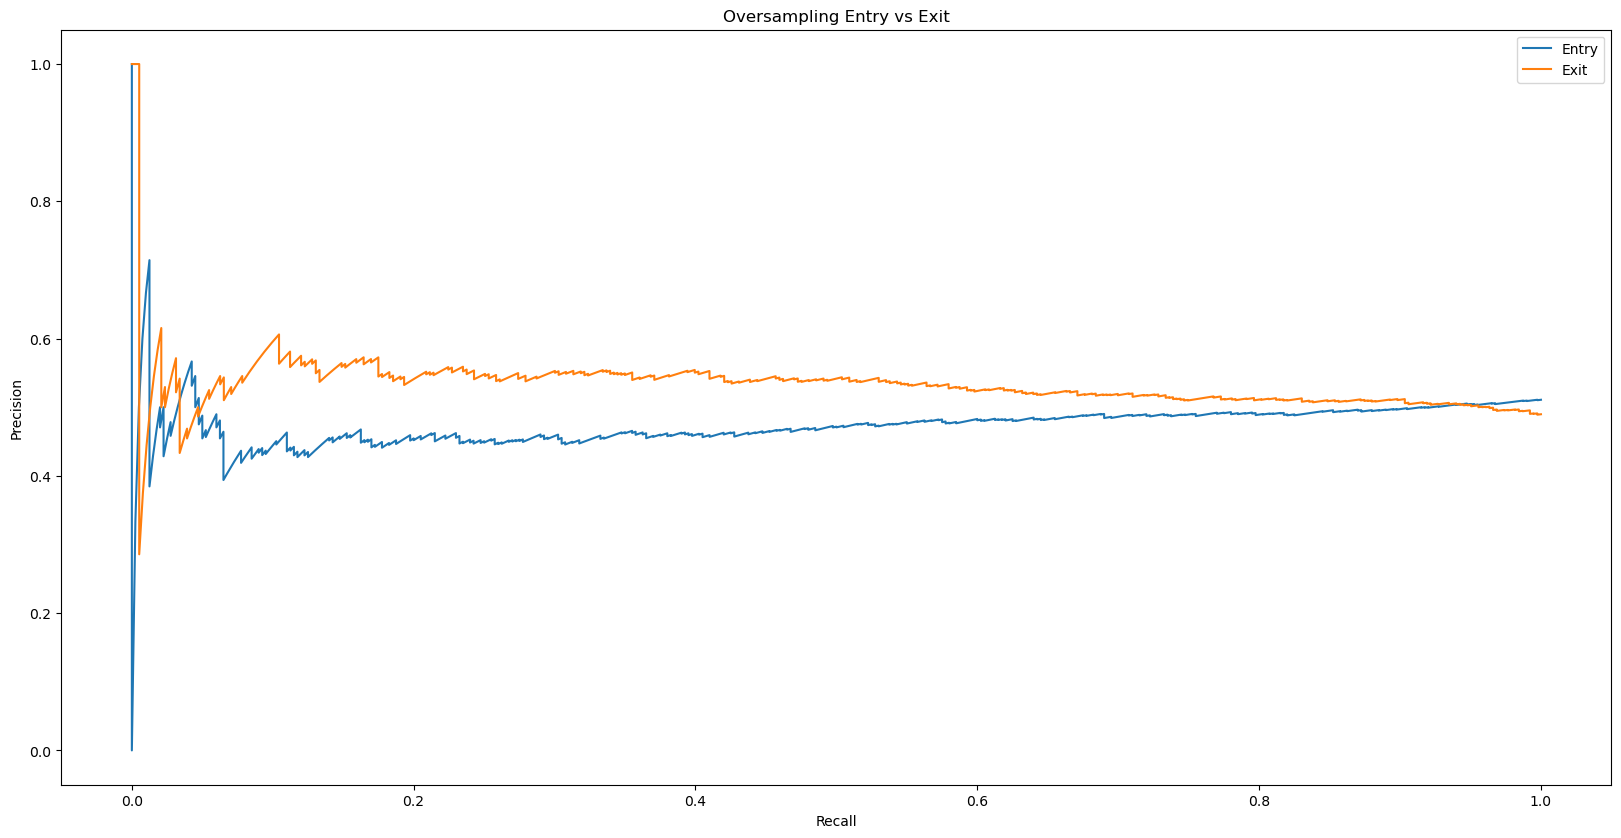

In [19]:
probs_os = model_over_resample.predict_proba(X_test_scaled)[:, 1]

precision_entry_os, recall_entry_os, _ = precision_recall_curve(y_test, probs_os, pos_label='Entry')
precision_exit_os, recall_exit_os, _ = precision_recall_curve(y_test, probs_os, pos_label='Exit')
plt.figure(figsize=(20,10), dpi=100)
plt.plot(recall_entry_os, precision_entry_os, label='Entry')
plt.plot(recall_exit_os, precision_exit_os,label='Exit')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Oversampling Entry vs Exit')
plt.savefig('Images\Precision Recall Oversampling.jpeg')
plt.show()

## SMOTE

In [20]:
X_resampled_smote, y_resampled_smote = SMOTE(random_state=78, sampling_strategy=1.0).fit_resample(
    X_train_scaled, y_train
)

Counter(y_resampled_smote)

Counter({'Exit': 963, 'Entry': 963})

In [21]:
model_smote = LogisticRegression(solver='lbfgs', random_state=78)
model_smote.fit(X_resampled_smote, y_resampled_smote)
y_pred_smote = model_smote.predict(X_test_scaled)
bac_smote = balanced_accuracy_score(y_test, y_pred_smote)
cm_smote = confusion_matrix(y_test, y_pred_smote)
cm_smote_df = pd.DataFrame(
    cm_smote, index=["Actual Entry", "Actual Exit"], columns=["Predicted Entry", "Predicted Exit"]
)

In [22]:
print('Confusion Matrix')
display(cm_smote_df)
print()
print()
print(f'Balance Accuracy Score: {bac_smote:.5f}')
print()
print()
print('Classification Report (Imbalanced)')
print(classification_report_imbalanced(y_test, y_pred_smote))

Confusion Matrix


,Predicted Entry,Predicted Exit
Actual Entry,170,230
Actual Exit,131,252




Balance Accuracy Score: 0.54148


Classification Report (Imbalanced)
                   pre       rec       spe        f1       geo       iba       sup

      Entry       0.56      0.42      0.66      0.49      0.53      0.27       400
       Exit       0.52      0.66      0.42      0.58      0.53      0.29       383

avg / total       0.54      0.54      0.54      0.53      0.53      0.28       783



In [23]:
classification_report_smote = pd.DataFrame(classification_report_imbalanced(y_test, y_pred_smote,digits=2, output_dict=True)).T
classification_report_smote.to_csv('Export Files\classification_report imbalanced (SMOTE).csv', index=False)
dfi.export(classification_report_smote.style.background_gradient(cmap='viridis', subset=pd.IndexSlice['Entry':'Exit']),'Images\\classification_report imbalanced (SMOTE).png')
classification_report_smote.style.background_gradient(cmap='viridis', subset=pd.IndexSlice['Entry':'Exit'])

,pre,rec,spe,f1,geo,iba,sup
Entry,0.564784,0.425000,0.657963,0.485021,0.528805,0.273120,400.000000
Exit,0.522822,0.657963,0.425000,0.582659,0.528805,0.286149,383.000000
avg_pre,0.544258,0.544258,0.544258,0.544258,0.544258,0.544258,0.544258
avg_rec,0.538953,0.538953,0.538953,0.538953,0.538953,0.538953,0.538953
avg_spe,0.544011,0.544011,0.544011,0.544011,0.544011,0.544011,0.544011
avg_f1,0.532780,0.532780,0.532780,0.532780,0.532780,0.532780,0.532780
avg_geo,0.528805,0.528805,0.528805,0.528805,0.528805,0.528805,0.528805
avg_iba,0.279493,0.279493,0.279493,0.279493,0.279493,0.279493,0.279493
total_support,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000


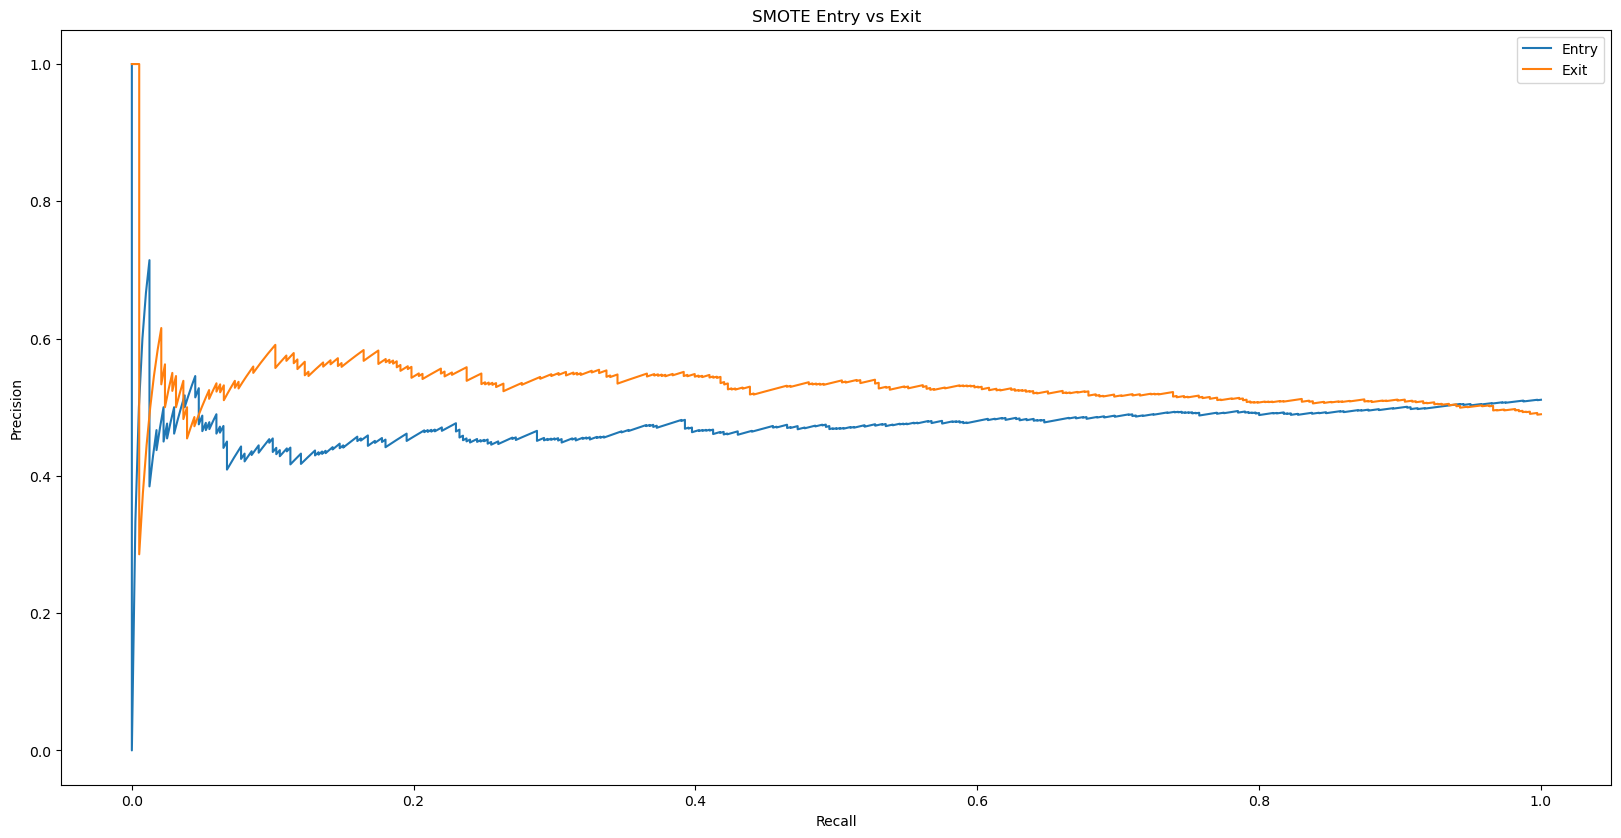

In [24]:
probs_smote = model_smote.predict_proba(X_test_scaled)[:, 1]

precision_entry_smote, recall_entry_smote, _ = precision_recall_curve(y_test, probs_smote, pos_label='Entry')
precision_exit_smote, recall_exit_smote, _ = precision_recall_curve(y_test, probs_smote, pos_label='Exit')
plt.figure(figsize=(20,10), dpi=100)
plt.plot(recall_entry_smote, precision_entry_smote, label='Entry')
plt.plot(recall_exit_smote, precision_exit_smote,label='Exit')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('SMOTE Entry vs Exit')
plt.savefig('Images\Precision Recall SMOTE.jpeg')
plt.show()

## Undersampling

In [25]:
rus = RandomUnderSampler(random_state=78)
X_under_resampled, y_under_resampled = ros.fit_resample(X_train_scaled, y_train)
Counter(y_under_resampled)

Counter({'Exit': 963, 'Entry': 963})

In [26]:
model_under_resample = LogisticRegression(solver='lbfgs', random_state=78)
model_under_resample.fit(X_under_resampled, y_under_resampled)
y_pred_under = model_under_resample.predict(X_test_scaled)
bac_under = balanced_accuracy_score(y_test, y_pred_under)
cm_under = confusion_matrix(y_test, y_pred_under)
cm_under_df = pd.DataFrame(
    cm_under, index=["Actual Entry", "Actual Exit"], columns=["Predicted Entry", "Predicted Exit"]
)

In [27]:
print('Confusion Matrix')
display(cm_under_df)
print()
print()
print(f'Balance Accuracy Score: {bac_under:.5f}')
print()
print()
print('Classification Report (Imbalanced)')
print(classification_report_imbalanced(y_test, y_pred_under))

Confusion Matrix


,Predicted Entry,Predicted Exit
Actual Entry,163,237
Actual Exit,126,257




Balance Accuracy Score: 0.53926


Classification Report (Imbalanced)
                   pre       rec       spe        f1       geo       iba       sup

      Entry       0.56      0.41      0.67      0.47      0.52      0.27       400
       Exit       0.52      0.67      0.41      0.59      0.52      0.28       383

avg / total       0.54      0.54      0.54      0.53      0.52      0.27       783



In [28]:
classification_report_us = pd.DataFrame(classification_report_imbalanced(y_test, y_pred_under,digits=2, output_dict=True)).T
classification_report_us.to_csv('Export Files\classification_report imbalanced (Undersampling).csv', index=False)
dfi.export(classification_report_us.style.background_gradient(cmap='viridis', subset=pd.IndexSlice['Entry':'Exit']),'Images\classification_report imbalanced (Undersampling).png')
classification_report_us.style.background_gradient(cmap='viridis', subset=pd.IndexSlice['Entry':'Exit'])

,pre,rec,spe,f1,geo,iba,sup
Entry,0.564014,0.407500,0.671018,0.473149,0.522915,0.266234,400.000000
Exit,0.520243,0.671018,0.407500,0.586089,0.522915,0.280646,383.000000
avg_pre,0.542604,0.542604,0.542604,0.542604,0.542604,0.542604,0.542604
avg_rec,0.536398,0.536398,0.536398,0.536398,0.536398,0.536398,0.536398
avg_spe,0.542120,0.542120,0.542120,0.542120,0.542120,0.542120,0.542120
avg_f1,0.528393,0.528393,0.528393,0.528393,0.528393,0.528393,0.528393
avg_geo,0.522915,0.522915,0.522915,0.522915,0.522915,0.522915,0.522915
avg_iba,0.273284,0.273284,0.273284,0.273284,0.273284,0.273284,0.273284
total_support,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000


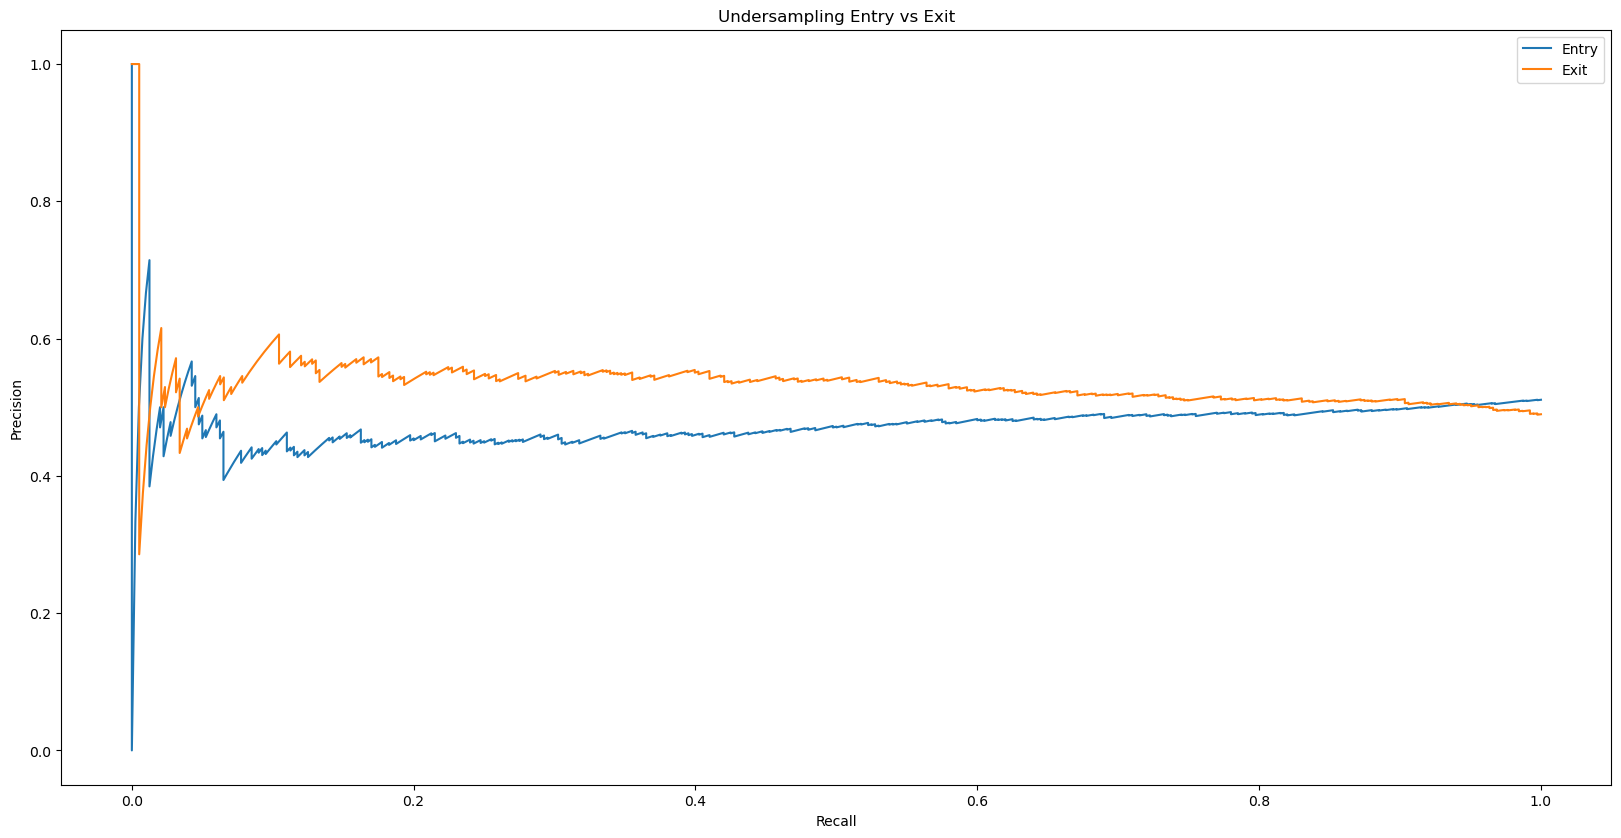

In [29]:
probs_us = model_under_resample.predict_proba(X_test_scaled)[:, 1]

precision_entry_us, recall_entry_us, _ = precision_recall_curve(y_test, probs_us, pos_label='Entry')
precision_exit_us, recall_exit_us, _ = precision_recall_curve(y_test, probs_us, pos_label='Exit')
plt.figure(figsize=(20,10), dpi=100)
plt.plot(recall_entry_us, precision_entry_us, label='Entry')
plt.plot(recall_exit_us, precision_exit_us,label='Exit')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Undersampling Entry vs Exit')
plt.savefig("Images\Precision Recall Undersampling.jpeg")
plt.show()

## Cluster Centroid Undersampling

In [30]:
cluster = ClusterCentroids(random_state=78)
X_resampled_cc, y_resampled_cc = cluster.fit_resample(X_train_scaled, y_train)
Counter(y_resampled_cc)

Counter({'Entry': 862, 'Exit': 862})

In [31]:
model_resample_cc = LogisticRegression(solver='lbfgs', random_state=78)
model_resample_cc.fit(X_resampled_cc, y_resampled_cc)
y_pred_cc = model_resample_cc.predict(X_test_scaled)
bac_cc = balanced_accuracy_score(y_test, y_pred_cc)
cm_cc = confusion_matrix(y_test, y_pred_cc)
cm_cc_df = pd.DataFrame(
    cm_cc, index=["Actual Entry", "Actual Exit"], columns=["Predicted Entry", "Predicted Exit"]
)

In [32]:
print('Confusion Matrix')
display(cm_cc_df)
print()
print()
print(f'Balance Accuracy Score: {bac_cc:.5f}')
print()
print()
print('Classification Report (Imbalanced)')
print(classification_report_imbalanced(y_test, y_pred_cc))

Confusion Matrix


,Predicted Entry,Predicted Exit
Actual Entry,140,260
Actual Exit,112,271




Balance Accuracy Score: 0.52879


Classification Report (Imbalanced)
                   pre       rec       spe        f1       geo       iba       sup

      Entry       0.56      0.35      0.71      0.43      0.50      0.24       400
       Exit       0.51      0.71      0.35      0.59      0.50      0.26       383

avg / total       0.53      0.52      0.53      0.51      0.50      0.25       783



In [33]:
classification_report_cc = pd.DataFrame(classification_report_imbalanced(y_test, y_pred_cc,digits=2, output_dict=True)).T
classification_report_cc.to_csv('Export Files\classification_report imbalanced (Cluster Centroid).csv', index=False)
dfi.export(classification_report_cc.style.background_gradient(cmap='viridis', subset=pd.IndexSlice['Entry':'Exit']),'Images\classification_report imbalanced (Cluster Centroid).png')
classification_report_cc.style.background_gradient(cmap='viridis', subset=pd.IndexSlice['Entry':'Exit'])

,pre,rec,spe,f1,geo,iba,sup
Entry,0.555556,0.350000,0.707572,0.429448,0.497645,0.238795,400.000000
Exit,0.510358,0.707572,0.350000,0.592998,0.497645,0.256505,383.000000
avg_pre,0.533447,0.533447,0.533447,0.533447,0.533447,0.533447,0.533447
avg_rec,0.524904,0.524904,0.524904,0.524904,0.524904,0.524904,0.524904
avg_spe,0.532668,0.532668,0.532668,0.532668,0.532668,0.532668,0.532668
avg_f1,0.509447,0.509447,0.509447,0.509447,0.509447,0.509447,0.509447
avg_geo,0.497645,0.497645,0.497645,0.497645,0.497645,0.497645,0.497645
avg_iba,0.247458,0.247458,0.247458,0.247458,0.247458,0.247458,0.247458
total_support,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000


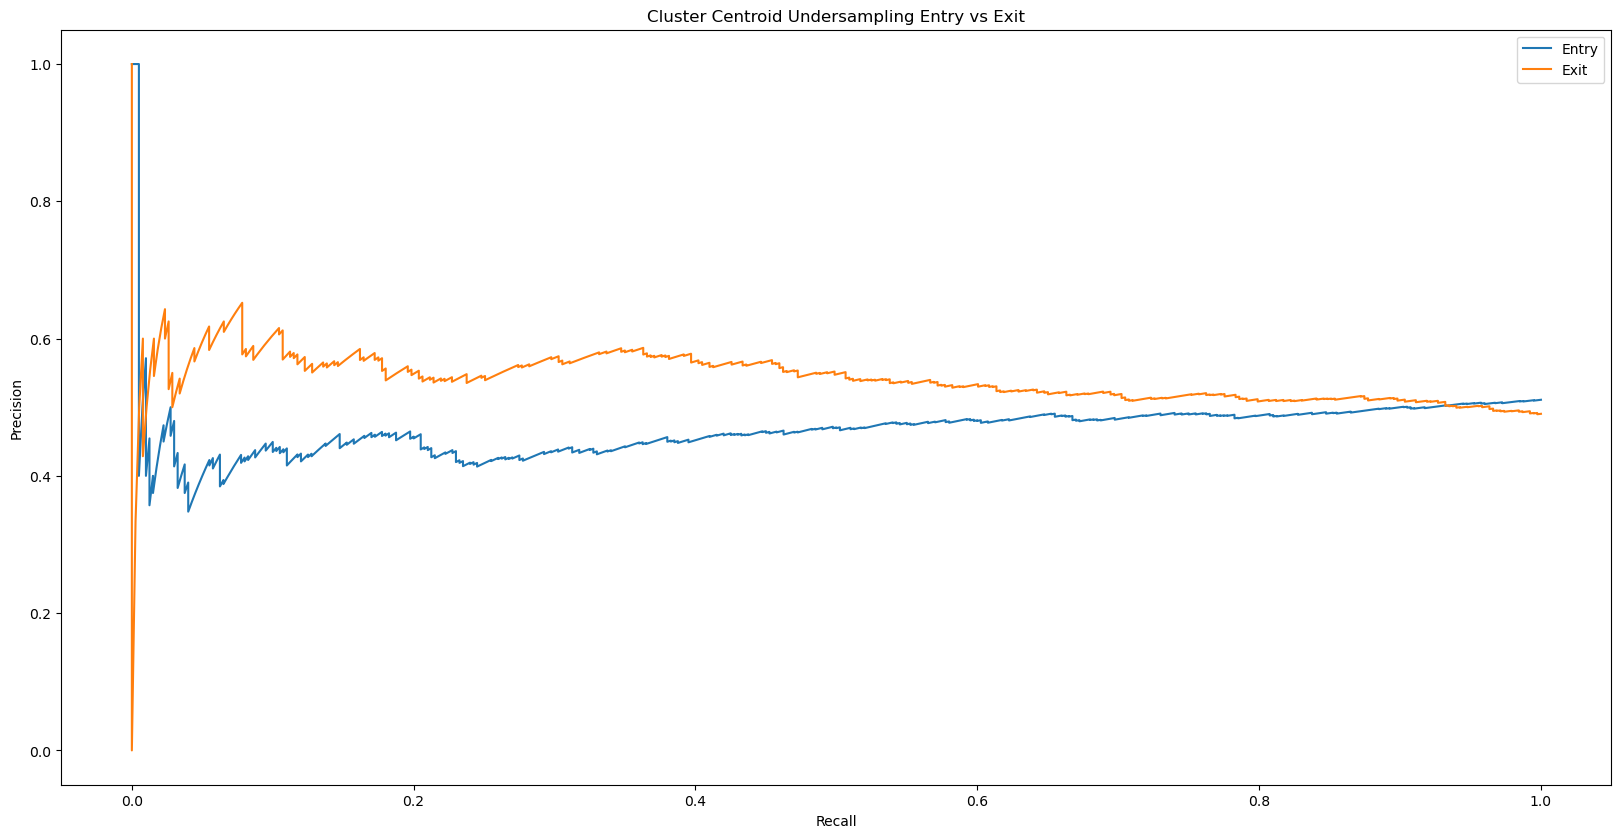

In [34]:
probs_cc = model_resample_cc.predict_proba(X_test_scaled)[:, 1]

precision_entry_cc, recall_entry_cc, _ = precision_recall_curve(y_test, probs_cc, pos_label='Entry')
precision_exit_cc, recall_exit_cc, _ = precision_recall_curve(y_test, probs_cc, pos_label='Exit')
plt.figure(figsize=(20,10), dpi=100)
plt.plot(recall_entry_cc, precision_entry_cc, label='Entry')
plt.plot(recall_exit_cc, precision_exit_cc,label='Exit')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Cluster Centroid Undersampling Entry vs Exit')
plt.savefig('Images\Precision Recall CC.jpeg')
plt.show()

## SMOTEEN

In [35]:
sm = SMOTEENN(random_state=78)
X_resampled_smoteenn, y_resampled_smoteenn = sm.fit_resample(X_train_scaled, y_train)
Counter(y_resampled_smoteenn)

Counter({'Entry': 139, 'Exit': 169})

In [36]:
model_smoteenn = LogisticRegression(solver='lbfgs', random_state=78)
model_smoteenn.fit(X_resampled_smoteenn, y_resampled_smoteenn)
y_pred_smoteenn = model_smoteenn.predict(X_test_scaled)
bac_smoteenn = balanced_accuracy_score(y_test, y_pred_smoteenn)
cm_smoteenn = confusion_matrix(y_test, y_pred_smoteenn)
cm_smoteenn_df = pd.DataFrame(
    cm_smoteenn, index=["Actual Entry", "Actual Exit"], columns=["Predicted Entry", "Predicted Exit"]
)

In [37]:
print('Confusion Matrix')
display(cm_smoteenn_df)
print()
print()
print(f'Balance Accuracy Score: {bac_smoteenn:.5f}')
print()
print()
print('Classification Report (Imbalanced)')
print(classification_report_imbalanced(y_test, y_pred_smoteenn))

Confusion Matrix


,Predicted Entry,Predicted Exit
Actual Entry,96,304
Actual Exit,82,301




Balance Accuracy Score: 0.51295


Classification Report (Imbalanced)
                   pre       rec       spe        f1       geo       iba       sup

      Entry       0.54      0.24      0.79      0.33      0.43      0.18       400
       Exit       0.50      0.79      0.24      0.61      0.43      0.20       383

avg / total       0.52      0.51      0.52      0.47      0.43      0.19       783



In [38]:
classification_report_smoteenn = pd.DataFrame(classification_report_imbalanced(y_test, y_pred_smoteenn,digits=2, output_dict=True)).T
classification_report_smoteenn.to_csv('Export Files\classification_report imbalanced (Smoteenn).csv', index=False)
dfi.export(classification_report_smoteenn.style.background_gradient(cmap='viridis', subset=pd.IndexSlice['Entry':'Exit']), 'Images\classification_report imbalanced (Smoteenn).png')
classification_report_smoteenn.style.background_gradient(cmap='viridis', subset=pd.IndexSlice['Entry':'Exit'])

,pre,rec,spe,f1,geo,iba,sup
Entry,0.539326,0.240000,0.785901,0.332180,0.434300,0.178320,400.000000
Exit,0.497521,0.785901,0.240000,0.609312,0.434300,0.198913,383.000000
avg_pre,0.518877,0.518877,0.518877,0.518877,0.518877,0.518877,0.518877
avg_rec,0.507024,0.507024,0.507024,0.507024,0.507024,0.507024,0.507024
avg_spe,0.518877,0.518877,0.518877,0.518877,0.518877,0.518877,0.518877
avg_f1,0.467737,0.467737,0.467737,0.467737,0.467737,0.467737,0.467737
avg_geo,0.434300,0.434300,0.434300,0.434300,0.434300,0.434300,0.434300
avg_iba,0.188393,0.188393,0.188393,0.188393,0.188393,0.188393,0.188393
total_support,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000


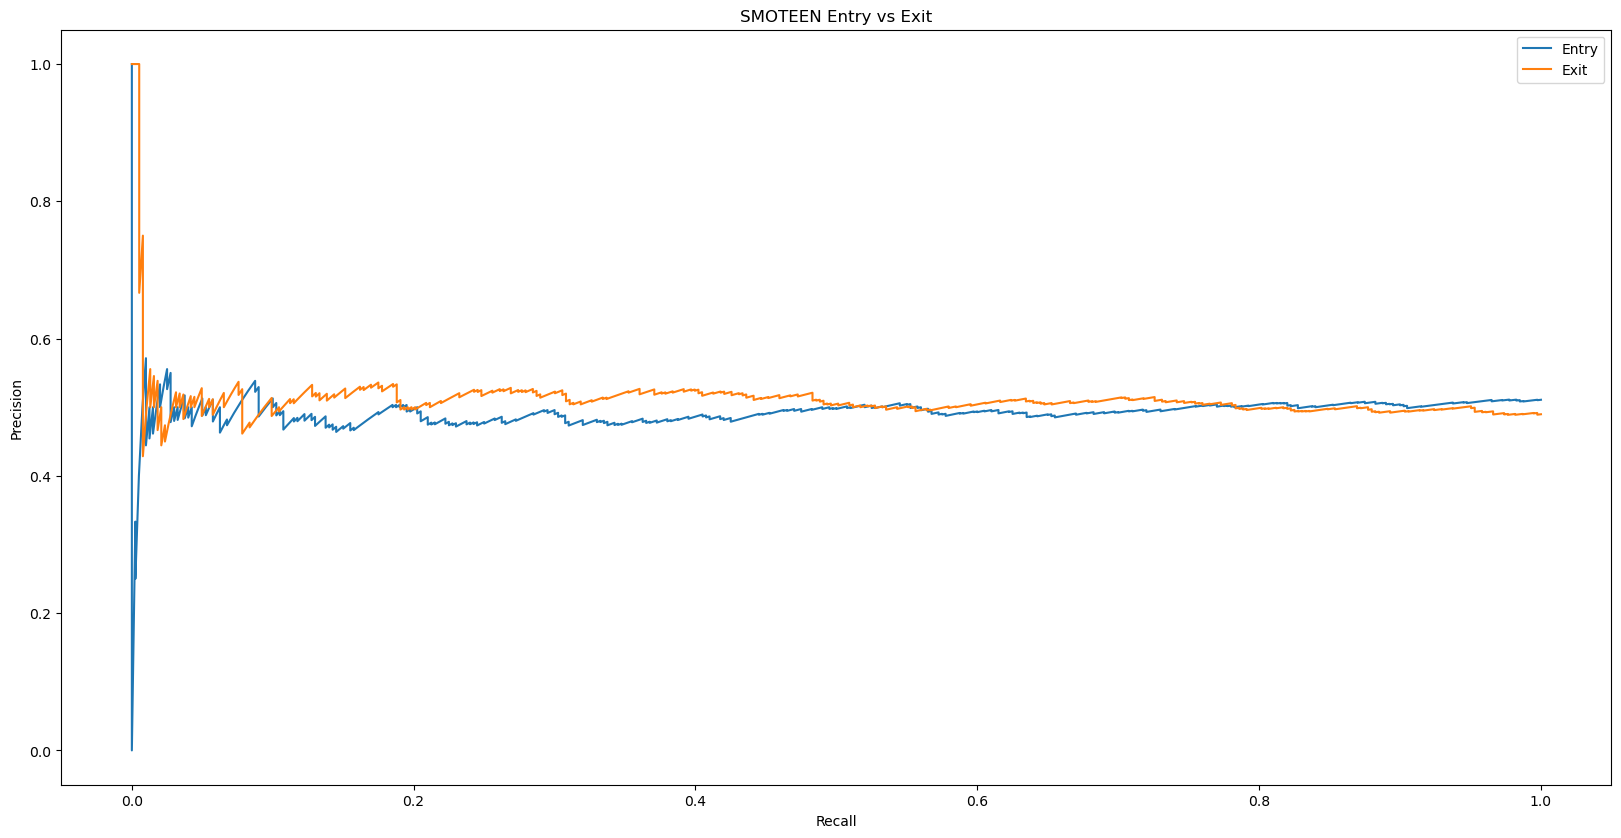

In [39]:
probs_smoteenn = model_smoteenn.predict_proba(X_test_scaled)[:, 1]

precision_entry_smoteenn, recall_entry_smoteenn, _ = precision_recall_curve(y_test, probs_smoteenn, pos_label='Entry')
precision_exit_smoteenn, recall_exit_smoteenn, _ = precision_recall_curve(y_test, probs_smoteenn, pos_label='Exit')
plt.figure(figsize=(20,10), dpi=100)
plt.plot(recall_entry_smoteenn, precision_entry_smoteenn, label='Entry')
plt.plot(recall_exit_smoteenn, precision_exit_smoteenn,label='Exit')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('SMOTEEN Entry vs Exit')
plt.savefig('Images\Precision Recall SMOTTEENN.jpeg')
plt.show()

## Balanced Random Forest Classifier

In [40]:
brf = BalancedRandomForestClassifier(n_estimators=1000, random_state=78)
brf.fit(X_train_scaled, y_train)
y_pred_brf = brf.predict(X_test_scaled)
bac_brf = balanced_accuracy_score(y_test, y_pred_brf)
cm_brf = confusion_matrix(y_test, y_pred_brf)
cm_brf_df = pd.DataFrame(
    cm_brf, index=["Actual Entry", "Actual Exit"], columns=["Predicted Entry", "Predicted Exit"]
)

C:\Users\Andy L\anaconda3\envs\alpacaenv\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [41]:
print('Confusion Matrix')
display(cm_brf_df)
print()
print()
print(f'Balance Accuracy Score: {bac_brf:.5f}')
print()
print()
print('Classification Report (Imbalanced)')
print(classification_report_imbalanced(y_test, y_pred_brf))

Confusion Matrix


,Predicted Entry,Predicted Exit
Actual Entry,200,200
Actual Exit,193,190




Balance Accuracy Score: 0.49804


Classification Report (Imbalanced)
                   pre       rec       spe        f1       geo       iba       sup

      Entry       0.51      0.50      0.50      0.50      0.50      0.25       400
       Exit       0.49      0.50      0.50      0.49      0.50      0.25       383

avg / total       0.50      0.50      0.50      0.50      0.50      0.25       783



In [42]:
classification_report_brf = pd.DataFrame(classification_report_imbalanced(y_test, y_pred_brf,digits=2, output_dict=True)).T
classification_report_brf.to_csv('Export Files\classification_report imbalanced (Balanced Random Forest).csv', index=False)
dfi.export(classification_report_brf.style.background_gradient(cmap='viridis', subset=pd.IndexSlice['Entry':'Exit']),'Images\\classification_report imbalanced (Balanced Random Forest).png')
classification_report_brf.style.background_gradient(cmap='viridis', subset=pd.IndexSlice['Entry':'Exit'])

,pre,rec,spe,f1,geo,iba,sup
Entry,0.508906,0.500000,0.496084,0.504414,0.498038,0.248139,400.000000
Exit,0.487179,0.496084,0.500000,0.491591,0.498038,0.247945,383.000000
avg_pre,0.498279,0.498279,0.498279,0.498279,0.498279,0.498279,0.498279
avg_rec,0.498084,0.498084,0.498084,0.498084,0.498084,0.498084,0.498084
avg_spe,0.497999,0.497999,0.497999,0.497999,0.497999,0.497999,0.497999
avg_f1,0.498142,0.498142,0.498142,0.498142,0.498142,0.498142,0.498142
avg_geo,0.498038,0.498038,0.498038,0.498038,0.498038,0.498038,0.498038
avg_iba,0.248044,0.248044,0.248044,0.248044,0.248044,0.248044,0.248044
total_support,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000


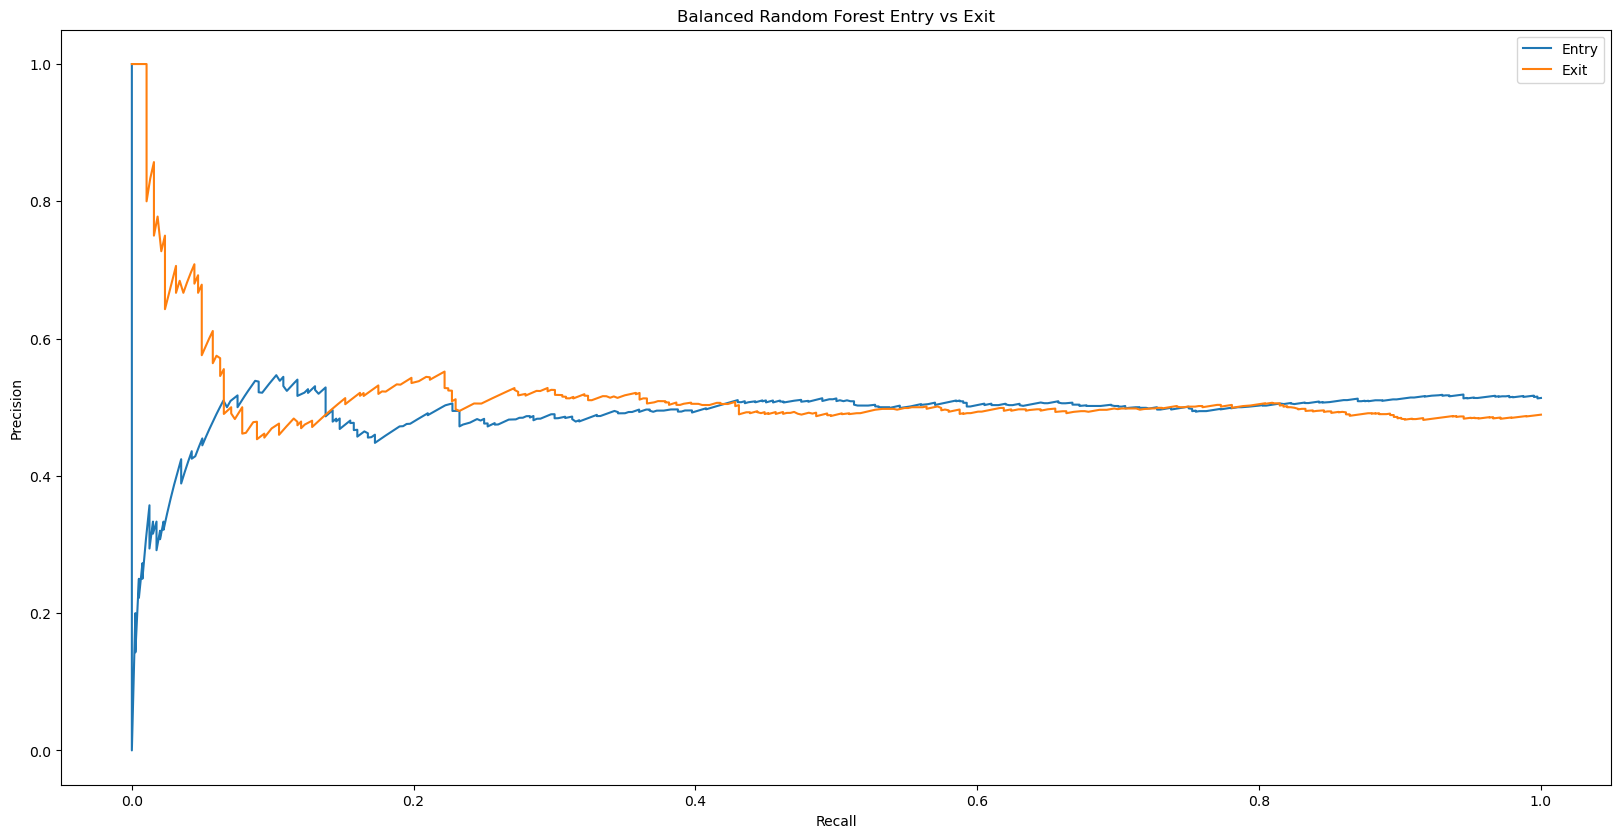

In [43]:
probs_brf = brf.predict_proba(X_test_scaled)[:, 1]

precision_entry_brf, recall_entry_brf, _ = precision_recall_curve(y_test, probs_brf, pos_label='Entry')
precision_exit_brf, recall_exit_brf, _ = precision_recall_curve(y_test, probs_brf, pos_label='Exit')
plt.figure(figsize=(20,10), dpi=100)
plt.plot(recall_entry_brf, precision_entry_brf, label='Entry')
plt.plot(recall_exit_brf, precision_exit_brf,label='Exit')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Balanced Random Forest Entry vs Exit')
plt.savefig('Images\Precision Recall BRF.jpeg')
plt.show()
